<a href="https://colab.research.google.com/github/whaldsz/deep-learning/blob/main/Disease_Indicators_Prediction_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disease Prediction



## Setup and initialization

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import math

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.utils.vis_utils import plot_model
import os

!pip install -q git+https://github.com/tensorflow/docs 


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("TensorFlow version::", tf.__version__)


from sklearn.model_selection import train_test_split

TensorFlow version:: 2.10.0


Traceback (most recent call last):
  File "C:\Users\whald\anaconda3\envs\tensorflow\Scripts\pip-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\site-packages\pip\_internal\cli\main.py", line 70, in main
    return command.main(cmd_args)
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\site-packages\pip\_internal\cli\base_command.py", line 101, in main
    return self._main(args)
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\contextlib.py", line 126, in __exit__
    next(self.gen)
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\site-packages\pip\_internal\cli\command_context.py", line 20, in main_context
    yield
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\contextlib.py", line 532, in __exit__
    raise exc_details[1]
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\contextlib.py", line 137, in __exit__
    self.gen.throw(typ, value, traceback)
  File "C:\Users\whald\anaconda3\envs\tensorflow\lib\si

In [2]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [3]:
# currentdir
logdir = os.path.join(os.getcwd(), "tensorboard_logs")
shutil.rmtree(logdir, ignore_errors=True)

In [4]:
# set random seed

tf.random.set_seed(74)

## 1. Dataset Preparation

In [5]:
disease_training = pd.read_csv('https://raw.githubusercontent.com/whaldsz/deep-learning/main/Disease_Prediction/Training.csv')
disease_testing = pd.read_csv('https://raw.githubusercontent.com/whaldsz/deep-learning/main/Disease_Prediction/Testing.csv')
disease_training.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

#3 Remove last column

In [7]:
disease_training.isna().sum()

itching                    0
skin_rash                  0
nodal_skin_eruptions       0
continuous_sneezing        0
shivering                  0
                        ... 
blister                    0
red_sore_around_nose       0
yellow_crust_ooze          0
prognosis                  0
Unnamed: 133            4920
Length: 134, dtype: int64

In [8]:
disease_training.drop('Unnamed: 133', inplace=True, axis=1)

disease_training.isna().sum()

itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64

In [9]:
#disease_training.head()

## Convert category to numeric values

In [10]:
#get class labels

class_names = np.unique(disease_training.prognosis)
disease_training.prognosis = pd.Categorical(disease_training.prognosis)
disease_testing.prognosis = pd.Categorical(disease_testing.prognosis)
class_names.shape

(41,)

In [11]:
#disease_training.prognosis.cat.codes
#disease_training
#disease_testing.head()

## Separate Features and Label - Training

### Training Set

In [12]:
X = disease_training.drop('prognosis', axis=1)
y = disease_training.prognosis.cat.codes
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int8)

### Unseen Test Set

In [13]:
X_unseen = disease_testing.drop('prognosis', axis=1)
y_unseen = disease_testing.prognosis.cat.codes
np.unique(X_unseen)

array([0, 1], dtype=int64)

## Split into Training & Validation Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)


In [15]:
X_test

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
4007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4462,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3280,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Number of features
FEATURES = X_test.shape[1]
FEATURES

132

## 2. Model Training

### Training configuration

In [17]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

### Create Model

### Find the ideal learning rate

In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

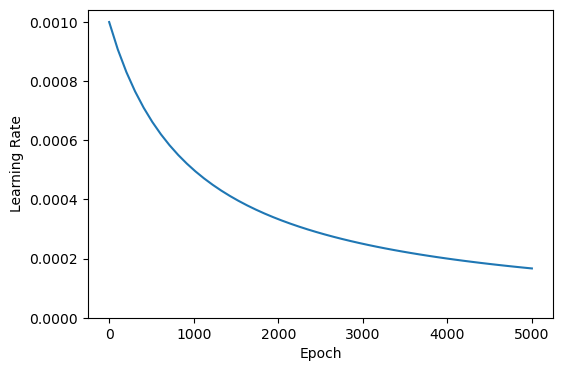

In [19]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (6,4))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [20]:
#lrs = 1e-4 * (10 ** (tf.range(40)/20))
#plt.figure(figsize=(6,4))
#plt.semilogx(lrs, history.history['loss'])
#plt.xlabel("Learning Rate")
#plt.ylabel("Loss")
#plt.title("Learning Rate vs Loss")

### Settings for automation

In [21]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=200),
    tf.keras.callbacks.TensorBoard(os.path.join(logdir,name)),
  ]

In [22]:
def compile_and_fit(model, name, loss=None, optimizer=None, metrics = None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()

  if loss is None:
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  if metrics is None:
    metrics = ['accuracy']
  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics
  )

  model.summary()

  history = model.fit(
    X_train,
    y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_split=0.1,
    #validation_data=[X_test, y_test],
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Models

In [23]:
size_histories = {}

#### Model 1

Simple model with 3 layers

In [24]:
model1 = tf.keras.Sequential([
    layers.Dense(4, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])

In [25]:
size_histories['model1'] = compile_and_fit(
    model1, 
    'models/model1', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 532       
                                                                 
 dense_1 (Dense)             (None, 41)                205       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0483,  loss:3.6876,  val_accuracy:0.0838,  val_loss:3.6475,  
....................................................................................................
Epoch: 100, accuracy:0.9737,  loss:0.3593,  val_accuracy:0.9797,  val_loss:0.3492,  
....................................................................................................
Epoch: 200, accuracy:0.9986,  loss:0.0684,  val_accuracy:1.0000,  val_loss:0.0643, 

#### Model 2

In [26]:
model2 = tf.keras.Sequential([
     layers.Dense(4, activation=tf.keras.activations.relu, input_shape=(FEATURES,)),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])


size_histories['model2'] = compile_and_fit(
    model2, 
    'models/model2', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

#model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                optimizer = tf.keras.optimizers.Adam(),
#                #metrics=['MultiClassConfusionMatrixPlot'])
#                metrics=["accuracy"])

#scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 **(epoch/20))

#history = model.fit(X_train, y_train, epochs=40, callbacks=[scheduler])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 532       
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 41)                205       
                                                                 
Total params: 757
Trainable params: 757
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0647,  loss:3.7011,  val_accuracy:0.0736,  val_loss:3.6948,  
....................................................................................................
Epoch: 100, accuracy:0.4102,  loss:1.8230,  val_accuracy:0.3680,  val_loss:1.8277,  
..................................................

#### Model 3

In [27]:
model3 = tf.keras.Sequential([
     layers.Dense(4, activation=tf.keras.activations.relu, input_shape=(FEATURES,)),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])


size_histories['model3'] = compile_and_fit(
    model3, 
    'models/model3', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 532       
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 41)                205       
                                                                 
Total params: 777
Trainable params: 777
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0308,  loss:3.7079,  val_accuracy:0.0533,  val_loss:3.7004,  
....................................................................................................
Epo

#### Model 4

In [28]:
model4 = tf.keras.Sequential([
     layers.Dense(4, activation=tf.keras.activations.relu, input_shape=(FEATURES,)),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])


size_histories['model4'] = compile_and_fit(
    model4, 
    'models/model4', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4)                 532       
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 4)                 20        
                                                                 
 dense_12 (Dense)            (None, 4)                 20        
                                                                 
 dense_13 (Dense)            (None, 41)                205       
                                                                 
Total params: 797
Trainable params: 797
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.0217,  loss:3.7097,  val_accuracy:

#### Model 5

In [29]:
model5 = tf.keras.Sequential([
     layers.Dense(4, activation=tf.keras.activations.relu, input_shape=(FEATURES,)),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(4, activation=tf.keras.activations.relu),
    layers.Dense(41, activation=tf.keras.activations.softmax)
])


size_histories['model5'] = compile_and_fit(
    model5, 
    'models/model5', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 4)                 532       
                                                                 
 dense_15 (Dense)            (None, 4)                 20        
                                                                 
 dense_16 (Dense)            (None, 4)                 20        
                                                                 
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
 dense_19 (Dense)            (None, 41)                205       
                                                                 
Total params: 817
Trainable params: 817
Non-trainable 

### 3. Evaluate Model

#### Evaluate with test data

In [30]:
loss1, acc1 = model1.evaluate(X_test, y_test)
loss2, acc2 = model2.evaluate(X_test, y_test)
loss3, acc3 = model3.evaluate(X_test, y_test)
loss4, acc4 = model4.evaluate(X_test, y_test)
loss5, acc5 = model5.evaluate(X_test, y_test)

print("Evaluation with Test Data")
print(f"Model 1 - Loss: {loss1}\t\tAccuracy: {acc1}")
print(f"Model 2 - Loss: {loss2}\t\tAccuracy: {acc2}")
print(f"Model 3 - Loss: {loss3}\t\tAccuracy: {acc3}")
print(f"Model 4 - Loss: {loss4}\t\tAccuracy: {acc4}")
print(f"Model 5 - Loss: {loss5}\t\tAccuracy: {acc5}")

31/31 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.9522
Evaluation with Test Data
Model 1 - Loss: 0.004560777917504311		Accuracy: 1.0
Model 2 - Loss: 0.7530283331871033		Accuracy: 0.772357702255249
Model 3 - Loss: 0.0013880555052310228		Accuracy: 1.0
Model 4 - Loss: 0.22868695855140686		Accuracy: 0.9115853905677795
Model 5 - Loss: 0.1934347301721573		Accuracy: 0.952235758304596


#### Evaluate with unseen data

In [31]:
loss1, acc1 = model1.evaluate(X_unseen, y_unseen)
loss2, acc2 = model2.evaluate(X_unseen, y_unseen)
loss3, acc3 = model3.evaluate(X_unseen, y_unseen)
loss4, acc4 = model4.evaluate(X_unseen, y_unseen)
loss5, acc5 = model5.evaluate(X_unseen, y_unseen)

print("Evaluation with Unseen Data")
print(f"Model 1 - Loss: {loss1}\t\tAccuracy: {acc1}")
print(f"Model 2 - Loss: {loss2}\t\tAccuracy: {acc2}")
print(f"Model 3 - Loss: {loss3}\t\tAccuracy: {acc3}")
print(f"Model 4 - Loss: {loss4}\t\tAccuracy: {acc4}")
print(f"Model 5 - Loss: {loss5}\t\tAccuracy: {acc5}")


2/2 [==============================] - 0s 5ms/step - loss: 18.0888 - accuracy: 0.9286
Evaluation with Unseen Data
Model 1 - Loss: 0.9025831818580627		Accuracy: 0.976190447807312
Model 2 - Loss: 0.8288834095001221		Accuracy: 0.738095223903656
Model 3 - Loss: 2.183349847793579		Accuracy: 0.976190447807312
Model 4 - Loss: 0.6413466930389404		Accuracy: 0.8809523582458496
Model 5 - Loss: 18.088783264160156		Accuracy: 0.9285714030265808


## 3. Testing

#### Test Set

In [32]:
### Test set
predictions = model.predict(X_test)
predictions[0]

NameError: name 'model' is not defined

In [ ]:
result = class_names[tf.argmax(predictions, axis=1)]


#### Unseen Test Data

In [ ]:
prediction_unseen_data = model.predict(X_unseen)

In [ ]:
result = class_names[tf.argmax(prediction_unseen_data, axis=1)]
result

### Correlation Matrix

In [ ]:
#plt.figure(figsize=(25,12))

#sns.heatmap(disease_training.corr().abs(), annot=True)
